In [1]:
!git clone https://github.com/arunsammit/MPNN-Ptr mpnn_ptr
%cd mpnn_ptr

Cloning into 'mpnn_ptr'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 219 (delta 105), reused 160 (delta 61), pack-reused 0
Receiving objects: 100% (219/219), 16.77 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/mpnn_ptr


In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 4.5 MB/s 
     |████████████████████████████████| 3.5 MB 32.2 MB/s 
     |████████████████████████████████| 2.3 MB 38.1 MB/s 
     |████████████████████████████████| 747 kB 67.0 MB/s 
     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 407 kB 51.3 MB/s 
     |████████████████████████████████| 45 kB 4.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=59f89d7d7d683816351f799096893b01285f884f2d46fe0d586494de83d8cc51
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


In [3]:
from models.mpnn_ptr import *
from models.mpnn import *
from models.seqToseq import *
from torch import nn
import torch
from utils.utils import communication_cost, calculate_baseline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [6]:
!ls

active_search.py  dpso.py    main.py  notebooks  requirements.txt  train.py
data		  graph.png  models   README.md  train.ipynb	   utils


In [7]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [8]:
dataloader, distance_matrices = torch.load('drive/MyDrive/data_MTP/data_64.pt')

In [9]:
dataloader.batch_size

128

In [10]:
max_graph_size = 64
mpnn_ptr = MpnnPtr(input_dim=max_graph_size, embedding_dim=75, hidden_dim=81, K=3, n_layers=4,p_dropout=0, logit_clipping=True, device=device)
mpnn_ptr.to(device)
mpnn_ptr.apply(init_weights)
optim = torch.optim.Adam(mpnn_ptr.parameters(), lr=0.0001)
num_epochs = 3500
epoch_penalty = torch.zeros(len(dataloader))
loss_list_pre = []

In [11]:
mpnn_ptr.train()

MpnnPtr(
  (mpnn): Mpnn(
    (node_init_embedding_layer): Sequential(
      (0): Linear(in_features=64, out_features=75, bias=False)
      (1): ReLU()
    )
    (theta4layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=150, out_features=75, bias=False)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=150, out_features=75, bias=False)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=150, out_features=75, bias=False)
        (1): ReLU()
      )
    )
    (theta5layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=150, out_features=75, bias=False)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=150, out_features=75, bias=False)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=150, out_features=75, bias=False)
        (1): ReLU()
      )
    )
    (theta6): Sequential(
      (0): Linear(in_features=75, out_f

In [12]:
mpnn_ptr = torch.load('./drive/MyDrive/data_MTP/model_64.pt')

In [13]:
for epoch in range(num_epochs):
    epoch_penalty[:] = 0
    for i, (data, distance_matrix) in enumerate(zip(dataloader, distance_matrices)):
        num_samples = 16
        
        samples, predicted_mappings, log_likelihoods_sum = mpnn_ptr(data,num_samples)
        # samples shape: (batch_size, num_samples, max_graph_size_in_batch)
        # predicted_mappings shape: (batch_size, max_graph_size_in_batch)
        # log_likelihoods_sum shape: (batch_size,)
        penalty = communication_cost(data.edge_index, data.edge_attr, data.batch, data.num_graphs, distance_matrix, predicted_mappings)
        epoch_penalty[i] = penalty.sum()
        penalty_baseline = calculate_baseline(data.edge_index, data.edge_attr, data.batch, data.num_graphs, distance_matrix, samples)
        loss = torch.mean((penalty.detach() - penalty_baseline.detach()) * log_likelihoods_sum)
        optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(mpnn_ptr.parameters(), max_norm=1, norm_type=2)
        optim.step()
    batch_loss = epoch_penalty.sum().item()
    loss_list_pre.append(batch_loss)
    print('Epoch: {}/{}, Loss: {}'.format(epoch + 1, num_epochs, batch_loss))

Epoch: 1/3500, Loss: 607951360.0
Epoch: 2/3500, Loss: 569881600.0
Epoch: 3/3500, Loss: 607878592.0
Epoch: 4/3500, Loss: 595688384.0
Epoch: 5/3500, Loss: 591987520.0
Epoch: 6/3500, Loss: 581865984.0
Epoch: 7/3500, Loss: 578791232.0
Epoch: 8/3500, Loss: 603216640.0
Epoch: 9/3500, Loss: 578995968.0
Epoch: 10/3500, Loss: 574925248.0
Epoch: 11/3500, Loss: 592623168.0
Epoch: 12/3500, Loss: 586439680.0
Epoch: 13/3500, Loss: 600851648.0
Epoch: 14/3500, Loss: 588803776.0
Epoch: 15/3500, Loss: 609179200.0
Epoch: 16/3500, Loss: 563419072.0
Epoch: 17/3500, Loss: 568187200.0
Epoch: 18/3500, Loss: 592933696.0
Epoch: 19/3500, Loss: 611940224.0
Epoch: 20/3500, Loss: 590531392.0
Epoch: 21/3500, Loss: 597836864.0
Epoch: 22/3500, Loss: 588621760.0
Epoch: 23/3500, Loss: 566624704.0
Epoch: 24/3500, Loss: 592940160.0
Epoch: 25/3500, Loss: 600026368.0
Epoch: 26/3500, Loss: 588273984.0
Epoch: 27/3500, Loss: 655909248.0
Epoch: 28/3500, Loss: 550594240.0
Epoch: 29/3500, Loss: 587214784.0
Epoch: 30/3500, Loss: 6

In [14]:
import matplotlib.pyplot as plt

In [15]:
torch.save(mpnn_ptr,'./drive/MyDrive/data_MTP/model_64.pt')

In [18]:
torch.save(loss_list_pre,'./drive/MyDrive/data_MTP/loss_list_pre_64.pt')

Text(0.5, 1.0, 'communication cost v/s number of epochs')

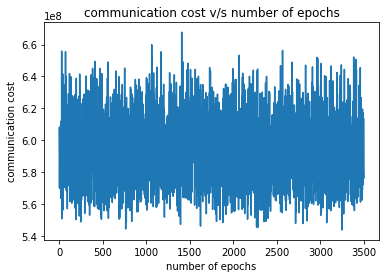

In [16]:
fig_pre, ax_pre = plt.subplots()  
ax_pre.plot(loss_list_pre)  
ax_pre.set_xlabel('number of epochs') 
ax_pre.set_ylabel('communication cost')  
ax_pre.set_title("communication cost v/s number of epochs")  